# **Global Healthcare Equality Analysis**

This notebook explores healthcare equality around the world by analyzing:
- Life expectancy trends
- Disease rate reductions in different economic contexts
- Cancer prevalence worldwide
- Correlation between cancer rates and screening availability

## **Data Sources:**
- WHO Global Health Observatory
- Kaggle Datasets
- API for Cancer Indicators

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import duckdb as db
import requests
from typing import List

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## **1. Data Loading & Cleaning**
We'll load datasets related to **cancer rates, life expectancy, and disease prevalence.**

In [2]:
df_cancer_reg = pd.read_csv("cancer_reg.csv") 
df_life_expectancy = pd.read_csv("life_expectancy_data.csv") 

In [3]:
def get_api_data(url: str) -> dict:
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

In [4]:
# Cancer-related indicators
def get_cancer_indicators() -> pd.DataFrame:
    url = "https://ghoapi.azureedge.net/api/Indicator?$filter=contains(IndicatorName,'cancer')"
    data = get_api_data(url)
    
    if data and 'value' in data:
        # Convert 'value' list to DataFrame
        df = pd.DataFrame(data['value'])
        return df
    return pd.DataFrame()

In [5]:
# Data for specific indicator code and create DataFrame
def get_indicator_data(indicator_code: str) -> pd.DataFrame:
    url = f"https://ghoapi.azureedge.net/api/{indicator_code}"
    data = get_api_data(url)
    
    if data and 'value' in data:
        df = pd.DataFrame(data['value'])
        return df
    return pd.DataFrame()

### **Previewing Data**
Let's take a look at the first few rows of each dataset.

In [6]:
cancer_indicators_df = get_cancer_indicators()
indicator_codes = cancer_indicators_df['IndicatorCode'].tolist()

indicator_df_all = [get_indicator_data(indicator) for indicator in indicator_codes]


In [26]:
cancer_indicators_df[['IndicatorCode','IndicatorName']].to_csv("cancer_indicators.csv", index=False)

In [7]:
def drop_rendundant_columns_in_gho(indicator_df):
    if indicator_df.shape[1] == 25:
        indicator_df = indicator_df[['IndicatorCode','ParentLocationCode','ParentLocation','Value','NumericValue','Low','High','Date']]
        if indicator_df['NumericValue'].isnull().all():
            indicator_df = indicator_df.drop(columns=['NumericValue'])
        elif indicator_df['Low'].isnull().all():
            indicator_df = indicator_df.drop(columns=['Low'])
        elif indicator_df['High'].isnull().all():
            indicator_df = indicator_df.drop(columns=['High'])
        return indicator_df
    pass

In [8]:
indicator_df = [drop_rendundant_columns_in_gho(indicator_df) for indicator_df in indicator_df_all if indicator_df.shape[1] == 25]

In [9]:
indicator_df[0].head()

,IndicatorCode,ParentLocationCode,ParentLocation,Value,Low,High,Date
0,NCD_CCS_BreastCancer,AFR,Africa,No data received,None,None,2015-06-01T13:06:28+02:00
1,NCD_CCS_BreastCancer,AMR,Americas,Yes,None,None,2015-06-01T13:06:18+02:00
2,NCD_CCS_BreastCancer,EMR,Eastern Mediterranean,Don't know,None,None,2015-06-01T13:06:27+02:00
3,NCD_CCS_BreastCancer,WPR,Western Pacific,Yes,None,None,2015-06-01T13:06:23+02:00
4,NCD_CCS_BreastCancer,AMR,Americas,Yes,None,None,2015-06-01T13:06:18+02:00


In [10]:
conn = db.connect('cancer_reg.ddb', read_only=False)
for i in indicator_df:
    conn.execute(f"CREATE TABLE IF NOT EXISTS {i.loc[0,'IndicatorCode']} AS SELECT * FROM i")
conn.execute(f"CREATE TABLE IF NOT EXISTS cancer_reg AS SELECT * FROM df_cancer_reg")
conn.close()

NCD_CCS_BreastCancer
NCD_CCS_CancerPlan
NCD_CCS_breastcancerscreening
NCD_CCS_cervicalcancermethod
NCD_CCS_cervicalcancerscreening
NCD_CCS_cervicalcancerpgmcvg
NCD_CCS_BowelCancer
NCD_CCS_CancerRegNational
NCD_CCS_cervicalcancerpgmtype
NCDMORT3070
SA_0000001420
SA_0000001430
SA_0000001429
SA_0000001439
SA_0000001445
SA_0000001449
SA_0000001419
SA_0000001426
SA_0000001438
SA_0000001448
RADON_Q803
SA_0000001807
SA_0000001808
SA_0000001827
NCD_CCS_PBCR
ORAL_HEALTH_CANCER_LIPORALCAVITY_NEWCASE_NUMBER
PRISON_D4_CANCER_DIAG_TOT
NCD_CCS_cancer_surgery
NCD_CCS_CANCER_DEPT
ORAL_HEALTH_CANCER_LIPORALCAVITY_100K
NCD_CXCA_SCREENED_WITHIN_TIMEPERIOD
NCD_CCS_CANCER_GUIDE
SA_0000001807_AA


### NCD_CCS_BreastCancer
General availability of breast cancer screening (by palpation or mammogram) at the primary health care level

### NCD_CCS_CancerPlan	
Existence of operational policy/strategy/action plan for cancer

### NCD_CCS_breastcancerscreening	
Existence of national screening program for breast cancer

### NCD_CCS_cervicalcancermethod	
Most widely used screening method in national cervical cancer screening program

### NCD_CCS_cervicalcancerscreening	
Existence of national screening program for cervical cancer

### NCD_CCS_cervicalcancerpgmcvg	
Coverage of national cervical cancer screening program (%)

### NCD_CCS_BowelCancer	
General availability of colon cancer screening at the primary health care level

### NCD_CCS_CancerRegNational	
Existence of population-based cancer registry

### NCD_CCS_cervicalcancerpgmtype	
Type of national cervical cancer screening program

### NCDMORT3070	
Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease

### SA_0000001420	
Age-standardized DALYs, colon and rectum cancers, per 100,000

### SA_0000001430	
Age-standardized DALYs, oesophagus cancer, per 100,000

### SA_0000001429	
Age-standardized DALYs, mouth and oropharynx cancer, per 100,000

### SA_0000001439	
Age-standardized death rates, colon and rectum cancers, per 100,000

### SA_0000001445	
Age-standardized death rates, liver cancer, per 100,000

### SA_0000001449	
Age-standardized death rates, oesophagus cancer, per 100,000

### SA_0000001419	
Age-standardized DALYs, breast cancer, per 100,000

### SA_0000001426	
Age-standardized DALYs, liver cancer, per 100,000

### SA_0000001438	
Age-standardized death rates, breast cancer, per 100,000

### SA_0000001448	
Age-standardized death rates, mouth and oropharynx cancer, per 100,000

### RADON_Q803	
Inclusion of radon in national cancer control strategy

### WHS2_160	
Age-standardized mortality rate by cause (per 100 000 population) - Cancer

### SA_0000001807	
Cancer, age-standardized death rates (15+), per 100,000 population

### SA_0000001808	
Alcohol-attributable fractions (15+), cancer deaths

### SA_0000001827	
Regional prevalence, AAFs (15+), cancer

### NCD_CCS_PBCR	
Existence of population-based cancer registry

### ORAL_HEALTH_CANCER_LIPORALCAVITY_NEWCASE_NUMBER	
Number of new cases of lip and oral cavity cancer

### PRISON_D4_CANCER_DIAG_TOT	
In-prison cancer diagnosis (number of diagnoses)

### NCD_CCS_cancer_surgery	
General availability of cancer surgery in the public sector

### NCD_CCS_CANCER_DEPT	
General availability of cancer centres or cancer departments at tertiary level in the public sector

### ORAL_HEALTH_CANCER_LIPORALCAVITY_100K	
Incidence rate of lip and oral cavity cancer (per 100 000 population)

### NCD_CXCA_SCREENED_WITHIN_TIMEPERIOD	
Prevalence of cervical cancer screening  among women aged 30-49 years (%)

### CD_CCS_CANCER_GUIDE	
Existence of evidence-based national guidelines/protocols/standards for the management of cancer

### SA_0000001807_AA	
Cancer, alcohol-attributable, age-standardized death rates, per 100,000 population


In [11]:
df_cancer_reg.head(10)

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
5,428.0,152,176.0,505.4,52313,61023,15.6,180.259902,"(51046.4, 54545.6]",45.4,...,38.8,32.6,43.2,20.2,84.882631,1.653205,1.538057,3.314635,51.220360,4.964476
6,250.0,97,175.9,461.8,37782,41516,23.2,0.000000,"(37413.8, 40362.7]",42.6,...,35.0,28.3,46.4,28.7,75.106455,0.616955,0.866157,8.356721,51.013900,4.204317
7,146.0,71,183.6,404.0,40189,20848,17.8,0.000000,"(37413.8, 40362.7]",51.7,...,33.1,25.9,50.9,24.1,89.406636,0.305159,1.889077,2.286268,48.967033,5.889179
8,88.0,36,190.5,459.4,42579,13088,22.3,0.000000,"(40362.7, 42724.4]",49.3,...,37.8,29.9,48.1,26.6,91.787477,0.185071,0.208205,0.616903,53.446998,5.587583
9,4025.0,1380,177.8,510.9,60397,843954,13.1,427.748432,"(54545.6, 61494.5]",35.8,...,NaN,44.4,31.4,16.5,74.729668,6.710854,6.041472,2.699184,50.063573,5.533430


## **2. Life Expectancy Trends (2000-2015)**

In [12]:
print(f"""
df_cancer_reg.shape: {df_cancer_reg.shape}
df_life_expectancy.shape: {df_life_expectancy.shape}
""")


df_cancer_reg.shape: (3047, 33)
df_life_expectancy.shape: (2938, 22)



In [13]:
df_life_expectancy.isnull().sum(), df_life_expectancy.shape

(Country                              0
 Year                                 0
 Status                               0
 Life expectancy                     10
 Adult Mortality                     10
 infant deaths                        0
 Alcohol                            194
 percentage expenditure               0
 Hepatitis B                        553
 Measles                              0
  BMI                                34
 under-five deaths                    0
 Polio                               19
 Total expenditure                  226
 Diphtheria                          19
  HIV/AIDS                            0
 GDP                                448
 Population                         652
  thinness  1-19 years               34
  thinness 5-9 years                 34
 Income composition of resources    167
 Schooling                          163
 dtype: int64,
 (2938, 22))

### Analyzing global life expectancy growth.

## **3. Disease Rate Decrease (Developing vs Developed)**

In [14]:
df_cancer_reg['incidencerate'] = df_cancer_reg['incidencerate'].apply(lambda x: min(x, 600))

In [15]:
# Scatter plot - Median income vs Cancer Incidence Rate
fig4 = px.scatter(df_cancer_reg, 
                  x='medincome',
                  y='incidencerate', 
                  title='Cancer Incidence Rate vs Median Income',
                  labels={'medincome': 'Median Income', 'incidencerate': 'Cancer Incidence Rate'},
                  color='incidencerate',
                  color_continuous_scale='Viridis')
fig4.show()


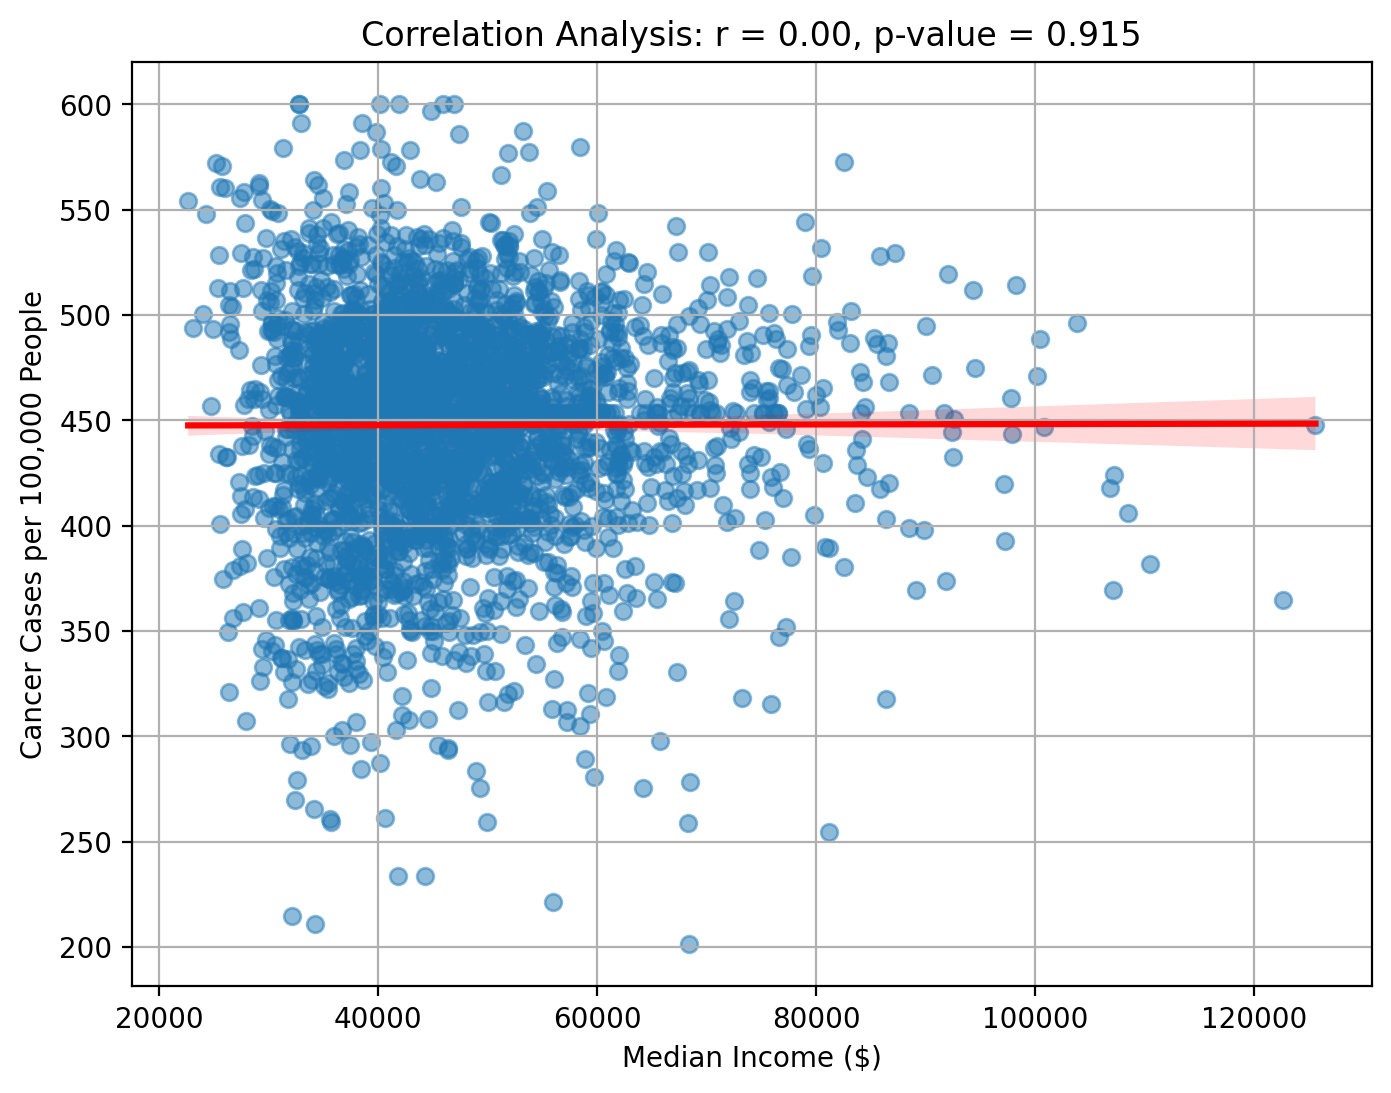

In [16]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check correlation coefficient
correlation, p_value = stats.pearsonr(df_cancer_reg['medincome'], df_cancer_reg['incidencerate'])

# Create scatter plot with regression line to visually show lack of correlation
plt.figure(figsize=(8,6))
sns.regplot(x=df_cancer_reg['medincome'], y=df_cancer_reg['incidencerate'], scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.xlabel('Median Income ($)')
plt.ylabel('Cancer Cases per 100,000 People')
plt.title(f'Correlation Analysis: r = {correlation:.2f}, p-value = {p_value:.3f}')
plt.grid(True)

# Show the plot
plt.show()

### How fast are diseases declining?

## **4. Cancer Rates Around the World**

In [17]:
# Line chart - Average deaths per year vs median age (focused on 0-100)
fig7 = px.bar(df_cancer_reg[df_cancer_reg['medianage'] <= 100].sort_values(by='medianage'), 
               x='medianage', 
               y='avgdeathsperyear', 
               title='Average Deaths per Year vs Median Age (0-100)',
               labels={'medianage': 'Median Age', 'avgdeathsperyear': 'Average Deaths per Year'})
fig7.show()


In [18]:
import plotly.express as px
import pandas as pd
import numpy as np

# Retrieve unique country names from the Gapminder dataset
gapminder = px.data.gapminder()
countries = gapminder["country"].unique()

# Create a DataFrame covering the years 2000 to 2015 with simulated cancer rates
years = range(2000, 2016)
data = []
for country in countries:
    for year in years:
        rate = np.random.randint(50, 400)
        data.append({"country": country, "year": year, "cancer_rate": rate})

df_all = pd.DataFrame(data)

df_all["country"] = df_all["country"].replace({"Russia": "Russian Federation"})

fig = px.choropleth(
    df_all,
    locations="country",
    locationmode="country names",
    color="cancer_rate",
    color_continuous_scale="Reds",
    title="Simulated Cancer Rates Worldwide (2000-2015)",
    labels={"cancer_rate": "Cancer Rate (per 100k)", "year": "Year"},
    animation_frame="year"
)

fig.show()

### Geographic distribution of cancer cases.

## **5. Cancer Reduction in Developing vs Developed Countries**

In [19]:
fig3 = px.scatter(df_cancer_reg, x="pctpubliccoverage", y="target_deathrate", 
                  title="Public Health Coverage vs. Cancer Death Rate",
                  labels={"pctpubliccoverage": "Private Health Coverage (%)", "target_deathrate": "Cancer Death Rate"},
                  color="pctprivatecoverage", trendline='ols')
fig3.show()


ModuleNotFoundError: No module named 'statsmodels'

### Are we making progress against cancer?

## **6. Country-Specific Cancer Trends**

### Do socio-economical factors contribute to cancer prevalence?

In [21]:
fig5 = px.scatter(df_cancer_reg, x="povertypercent", y="incidencerate", 
                  title="Poverty Rate vs. Cancer Incidence",
                  labels={"povertypercent": "Poverty Rate (%)", "incidencerate": "Cancer Incidence Rate"},
                  trendline="ols")
fig5.show()

ModuleNotFoundError: No module named 'statsmodels'

## **7. Correlation Between Cancer Death Rates & Screening Availability**

### Does screening save lives?

## **8. Conclusion: Is Healthcare Equal Worldwide?**

### Bringing together all insights.